Kết nối Colab với Google Drive để lấy dữ liệu

Cài đặt thư viện Gensim cho việc train model Word2Vec

Import các thư viện cần thiết

In [1]:
import os
import re
import pandas as pd
import string
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrzaizai2k/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrzaizai2k/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load tập dữ liệu từ thư mục trong Google Drive

In [2]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")

# train_data = load_data("Corona_NLP_train.csv").iloc[:2000]

# train_data = train_data["OriginalTweet"].to_list()
# train_data = "\n".join(train_data)

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/gretelai/synthetic-gsm8k-reflection-405b/" + splits["train"])
df = df[df['topic'].isin(['arithmetic', 'percentages'])]
df = df[['topic', 'question']].rename(columns={'topic': 'label', 'question': 'text'})

train_data = df["text"].to_list()
train_data = "\n".join(train_data)
print(train_data[:1000])


stopwords_list=stopwords.words('english')

# Clean data function
def clean_data(w):
    w = w.lower()  # Convert to lowercase
    w = re.sub(r"'s\b", "", w)  # Remove possessive "'s"
    w = re.sub("[^a-zA-Z]", " ", w)  # Replace non-alphabetical characters with space
    words = w.split()  # Split the string into words
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]  # Filter stopwords and short words
    return " ".join(clean_words)  # Join back into a string

# Function to process list of sentences
def get_inp(list_sent):
    sent = list(map(clean_data, list_sent))  # Clean each sentence
    sent = [s.split(" ") for s in sent if s.strip()]  # Split into words and avoid empty sentences
    return sent

# Process the input data
inp_data = get_inp(train_data.split("\n"))
print(inp_data[:5])  # Print the first 5 results

/home/mrzaizai2k/code_Bao/Nlp_co5256/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


During Dia de los Muertos, a store in Mexico City offers a 15% discount on all traditional costumes. If a customer also signs up for the store's newsletter, they receive an additional 5% discount. What is the total percentage discount a customer can receive on a traditional Dia de los Muertos costume?
Kaito is traveling from Tokyo to Seoul and wants to book a flight ticket that originally costs $500. The airline is offering a 15% discount for students, but there's an additional 5% service charge. What is the final amount Kaito needs to pay for the ticket?
Tom is shopping for a new pair of sneakers at a local store in Amsterdam. He has a 20% discount coupon for any purchase over €80 and a 15% discount coupon for any purchase under €80. The store is also offering a 5% discount on all sales over €100. If Tom wants to buy a pair of sneakers originally priced at €120 and a hoodie originally priced at €40, should he buy them together or separately to get the best discount, and what will be t

In [3]:
print(len(inp_data))

5089


Train model Word2Vec. Trong quá trình train, có bạn có thể chỉnh sử dụng GPU của Colab để đẩy nhanh tiến độ bằng cách vào Rumtime => Change Runtime Type và chọn GPU

In [4]:
# Skipgram model
model = Word2Vec(inp_data, min_count = 1, vector_size = 256, window = 5, sg = 1)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
model.wv.save('word2vec_skipgram.bin')


# CBOW model
model = Word2Vec(inp_data, min_count = 1, vector_size = 256, window = 5, sg = 0)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
model.wv.save('word2vec_CBOW.bin')


Sau khi có model. Ta tiến hành load mô hình

In [5]:
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from scipy.spatial import distance
path = 'word2vec_CBOW.bin'
model = gensim.models.KeyedVectors.load(path)

In [6]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for word in model.index_to_key:
        f.write(word + "\n")

Test kết quả

In [8]:
model.most_similar(positive=['advanced'], topn=10)

[('whistler', 0.9772836565971375),
 ('leiden', 0.9748424887657166),
 ('trips', 0.9742493629455566),
 ('return', 0.9741085767745972),
 ('sites', 0.9737952351570129),
 ('varying', 0.9731966257095337),
 ('charlie', 0.9731631278991699),
 ('traveler', 0.973138689994812),
 ('site', 0.9729405045509338),
 ('campsites', 0.9721770882606506)]

In [10]:
word_0 = "advanced"
word_1 = "cost"
word_2 = "discount"

word_0_eb = model[word_0]
word_1_eb = model[word_1]
word_2_eb = model[word_2]

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

OUTPUT DISTANCE
0 vs 1:  6.489919662475586
1 vs 2:  7.387387752532959
2 vs 0:  8.909451484680176


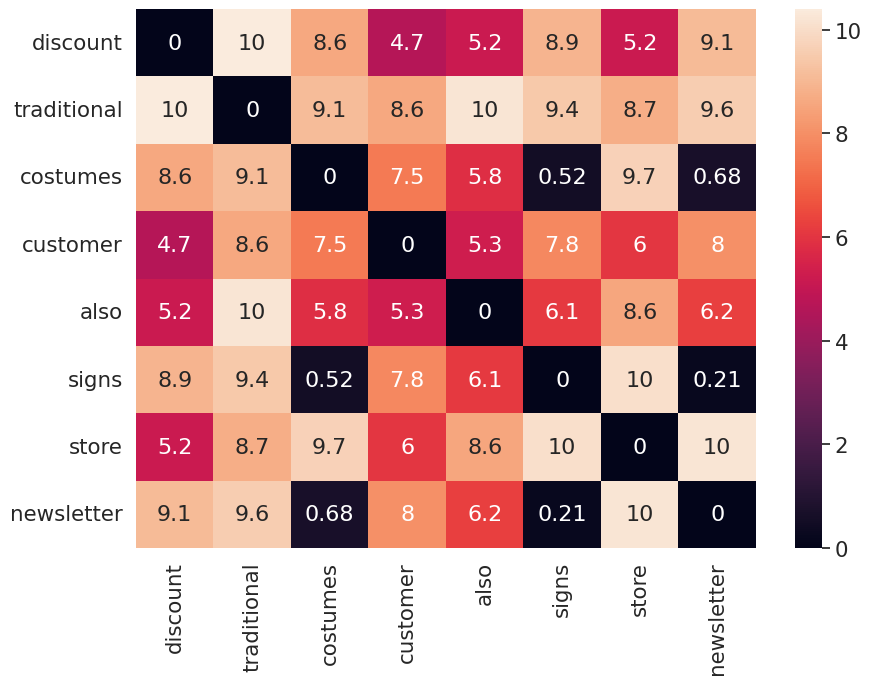

In [12]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ['discount', 'traditional', 'costumes', 'customer', 'also', 'signs', 'store', 'newsletter', ]
list_word_embs = list(map(lambda x: model[x], list_words))

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
